Dataset: https://www.kaggle.com/blastchar/telco-customer-churn

##  Libraries

In [1]:
install.packages("ROSE")

Installing package into ‘/work/.R/library’
(as ‘lib’ is unspecified)



In [2]:
library(dummies)
library(caret)
library(e1071)
library(ROSE)
library(corrplot)
library(rpart)
library(rpart.plot)
library(dplyr)
library(randomForest)
library(ROCR)
library(ipred)

dummies-1.5.6 provided by Decision Patterns


Loading required package: lattice

Loading required package: ggplot2

Loaded ROSE 0.0-3


corrplot 0.84 loaded


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin




## Data Preprocessing

In [3]:
data <- read.csv(file="WA_Fn-UseC_-Telco-Customer-Churn.csv")
df <- as.data.frame(unclass(data), stringsAsFactors=TRUE)

In [4]:
str(df)

'data.frame':	7043 obs. of  21 variables:
 $ customerID      : Factor w/ 7043 levels "0002-ORFBO","0003-MKNFE",..: 5376 3963 2565 5536 6512 6552 1003 4771 5605 4535 ...
 $ gender          : Factor w/ 2 levels "Female","Male": 1 2 2 2 1 1 2 1 1 2 ...
 $ SeniorCitizen   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Partner         : Factor w/ 2 levels "No","Yes": 2 1 1 1 1 1 1 1 2 1 ...
 $ Dependents      : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 2 1 1 2 ...
 $ tenure          : int  1 34 2 45 2 8 22 10 28 62 ...
 $ PhoneService    : Factor w/ 2 levels "No","Yes": 1 2 2 1 2 2 2 1 2 2 ...
 $ MultipleLines   : Factor w/ 3 levels "No","No phone service",..: 2 1 1 2 1 3 3 2 3 1 ...
 $ InternetService : Factor w/ 3 levels "DSL","Fiber optic",..: 1 1 1 1 2 2 2 1 2 1 ...
 $ OnlineSecurity  : Factor w/ 3 levels "No","No internet service",..: 1 3 3 3 1 1 1 3 1 3 ...
 $ OnlineBackup    : Factor w/ 3 levels "No","No internet service",..: 3 1 3 1 1 1 3 1 1 3 ...
 $ DeviceProtection: Factor w/ 3 levels "No","

In [5]:
# Change senior citizen to factor
df$SeniorCitizen <- as.factor(df$SeniorCitizen)

# Change levels of factor variables
levels(df$MultipleLines) <- c("0", "0", "1")
levels(df$OnlineBackup) <- c("0", "0", "1")
levels(df$DeviceProtection) <- c("0", "0", "1")
levels(df$TechSupport) <- c("0", "0", "1")
levels(df$OnlineSecurity) <- c("0", "0", "1")
levels(df$StreamingMovies) <- c("0", "0", "1")
levels(df$StreamingTV) <- c("0", "0", "1")
levels(df$PaperlessBilling) <- c("0", "1")
levels(df$PhoneService) <- c("0", "1")
levels(df$Partner) <- c("0", "1")
levels(df$Dependents) <- c("0", "1")
levels(df$Churn) <- c("0", "1")

# Drop column customerID since we're not using it
df <- subset(df, select = -c(customerID))

In [6]:
# Create dummy variables
df <- dummy.data.frame(df, names = c("PaymentMethod", "Contract", "InternetService") , sep = ".")

Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”
Warning message in model.matrix.default(~x - 1, model.frame(~x - 1), contrasts = FALSE):
“non-list contrasts argument ignored”


In [7]:
# Replace spaces in names of variables
names(df) <- gsub(" ", "_", names(df))
# Replace dashes in names of variables
names(df) <- gsub("-", "_", names(df))

# Renaming data frame
names(df)[names(df) == "PaymentMethod.Bank_transfer_(automatic)"] <- "PaymentMethod.Bank_transfer"
names(df)[names(df) == "PaymentMethod.Credit_card_(automatic)"] <- "PaymentMethod.Credit_card"  

In [8]:
# First 6 rows of data
head(df)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService.DSL,InternetService.Fiber_optic,InternetService.No,⋯,Contract.One_year,Contract.Two_year,PaperlessBilling,PaymentMethod.Bank_transfer,PaymentMethod.Credit_card,PaymentMethod.Electronic_check,PaymentMethod.Mailed_check,MonthlyCharges,TotalCharges,Churn
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<int>,<int>,<int>,⋯,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>
1,Female,0,1,0,1,0,0,1,0,0,⋯,0,0,1,0,0,1,0,29.85,29.85,0
2,Male,0,0,0,34,1,0,1,0,0,⋯,1,0,0,0,0,0,1,56.95,1889.50,0
3,Male,0,0,0,2,1,0,1,0,0,⋯,0,0,1,0,0,0,1,53.85,108.15,1
4,Male,0,0,0,45,0,0,1,0,0,⋯,1,0,0,1,0,0,0,42.30,1840.75,0
5,Female,0,0,0,2,1,0,0,1,0,⋯,0,0,1,0,0,1,0,70.70,151.65,1
6,Female,0,0,0,8,1,1,0,1,0,⋯,0,0,1,0,0,1,0,99.65,820.50,1


In [9]:
str(df)

'data.frame':	7043 obs. of  27 variables:
 $ gender                        : Factor w/ 2 levels "Female","Male": 1 2 2 2 1 1 2 1 1 2 ...
 $ SeniorCitizen                 : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Partner                       : Factor w/ 2 levels "0","1": 2 1 1 1 1 1 1 1 2 1 ...
 $ Dependents                    : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 2 1 1 2 ...
 $ tenure                        : int  1 34 2 45 2 8 22 10 28 62 ...
 $ PhoneService                  : Factor w/ 2 levels "0","1": 1 2 2 1 2 2 2 1 2 2 ...
 $ MultipleLines                 : Factor w/ 2 levels "0","1": 1 1 1 1 1 2 2 1 2 1 ...
 $ InternetService.DSL           : int  1 1 1 1 0 0 0 1 0 1 ...
 $ InternetService.Fiber_optic   : int  0 0 0 0 1 1 1 0 1 0 ...
 $ InternetService.No            : int  0 0 0 0 0 0 0 0 0 0 ...
 $ OnlineSecurity                : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 2 1 2 ...
 $ OnlineBackup                  : Factor w/ 2 levels "0","1": 2 1 2 1 1 1 2 1 

In [10]:
nrow(df)

[1] 7043

7043 data points

## Test for NAs

In [11]:
testForNA <- function(df) {
    return(apply(df, 2, function(x) any(is.na(x))))
}

In [12]:
testForNA(df)

gender                  SeniorCitizen 
                         FALSE                          FALSE 
                       Partner                     Dependents 
                         FALSE                          FALSE 
                        tenure                   PhoneService 
                         FALSE                          FALSE 
                 MultipleLines            InternetService.DSL 
                         FALSE                          FALSE 
   InternetService.Fiber_optic             InternetService.No 
                         FALSE                          FALSE 
                OnlineSecurity                   OnlineBackup 
                         FALSE                          FALSE 
              DeviceProtection                    TechSupport 
                         FALSE                          FALSE 
                   StreamingTV                StreamingMovies 
                         FALSE                          FALSE 
       Contract.Month_to_month              Contract.One_year 
                         FALSE                          FALSE 
             Contract.Two_year               PaperlessBilling 
                         FALSE                          FALSE 
   PaymentMethod.Bank_transfer      PaymentMethod.Credit_card 
                         FALSE                          FALSE 
PaymentMethod.Electronic_check     PaymentMethod.Mailed_check 
                         FALSE                          FALSE 
                MonthlyCharges                   TotalCharges 
                         FALSE                           TRUE 
                         Churn 
                         FALSE

We see that TotalCharges contain NA values

In [13]:
df <- na.omit(df) # Drop rows with NA
testForNA(df)

gender                  SeniorCitizen 
                         FALSE                          FALSE 
                       Partner                     Dependents 
                         FALSE                          FALSE 
                        tenure                   PhoneService 
                         FALSE                          FALSE 
                 MultipleLines            InternetService.DSL 
                         FALSE                          FALSE 
   InternetService.Fiber_optic             InternetService.No 
                         FALSE                          FALSE 
                OnlineSecurity                   OnlineBackup 
                         FALSE                          FALSE 
              DeviceProtection                    TechSupport 
                         FALSE                          FALSE 
                   StreamingTV                StreamingMovies 
                         FALSE                          FALSE 
       Contract.Month_to_month              Contract.One_year 
                         FALSE                          FALSE 
             Contract.Two_year               PaperlessBilling 
                         FALSE                          FALSE 
   PaymentMethod.Bank_transfer      PaymentMethod.Credit_card 
                         FALSE                          FALSE 
PaymentMethod.Electronic_check     PaymentMethod.Mailed_check 
                         FALSE                          FALSE 
                MonthlyCharges                   TotalCharges 
                         FALSE                          FALSE 
                         Churn 
                         FALSE

Now there's no more rows with NAs

## Data Exploration

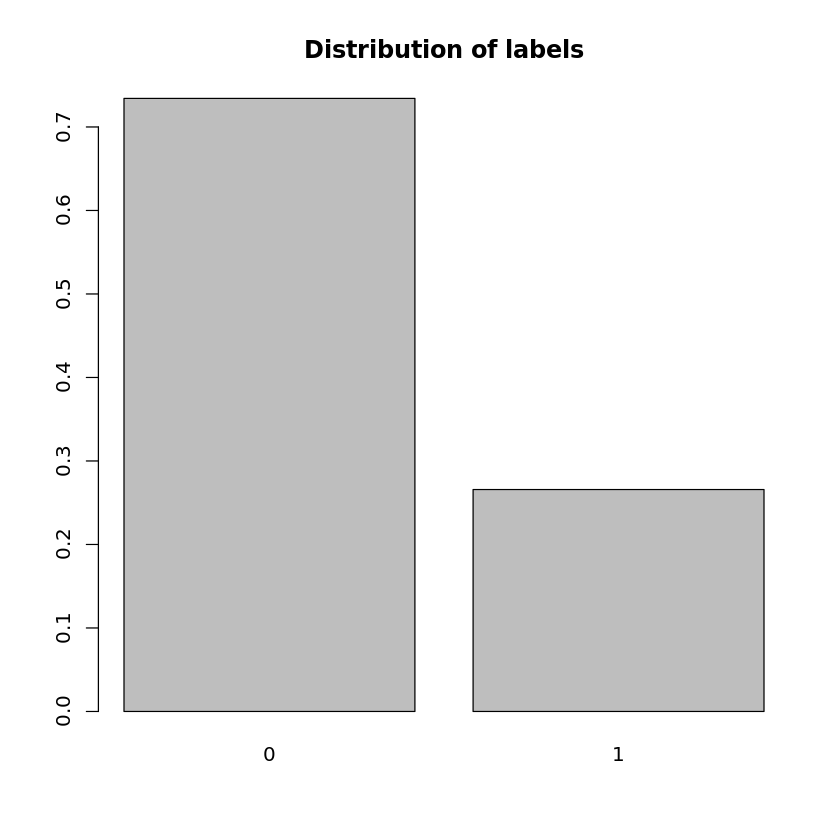

In [14]:
# Distribution of labels
barplot(prop.table(table(df$Churn)), main="Distribution of labels")

#### Correlation plot

In [15]:
corrPlotDF <- df

In [16]:
corrPlotDF$gender <- as.integer(corrPlotDF$gender)
corrPlotDF$SeniorCitizen <- as.integer(corrPlotDF$SeniorCitizen)
corrPlotDF$MultipleLines <- as.integer(corrPlotDF$MultipleLines)
corrPlotDF$OnlineSecurity <- as.integer(corrPlotDF$OnlineSecurity)
corrPlotDF$DeviceProtection <- as.integer(corrPlotDF$DeviceProtection)
corrPlotDF$TechSupport <- as.integer(corrPlotDF$TechSupport)
corrPlotDF$OnlineBackup <- as.integer(corrPlotDF$OnlineBackup)
corrPlotDF$StreamingMovies <- as.integer(corrPlotDF$StreamingMovies)
corrPlotDF$StreamingTV <- as.integer(corrPlotDF$StreamingTV)
corrPlotDF$PaperlessBilling <- as.integer(corrPlotDF$PaperlessBilling)
corrPlotDF$PhoneService <- as.integer(corrPlotDF$PhoneService)
corrPlotDF$Partner <- as.integer(corrPlotDF$Partner)
corrPlotDF$Dependents <- as.integer(corrPlotDF$Dependents)
corrPlotDF$Churn <- as.integer(corrPlotDF$Churn)

In [17]:
str(corrPlotDF)

'data.frame':	7032 obs. of  27 variables:
 $ gender                        : int  1 2 2 2 1 1 2 1 1 2 ...
 $ SeniorCitizen                 : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Partner                       : int  2 1 1 1 1 1 1 1 2 1 ...
 $ Dependents                    : int  1 1 1 1 1 1 2 1 1 2 ...
 $ tenure                        : int  1 34 2 45 2 8 22 10 28 62 ...
 $ PhoneService                  : int  1 2 2 1 2 2 2 1 2 2 ...
 $ MultipleLines                 : int  1 1 1 1 1 2 2 1 2 1 ...
 $ InternetService.DSL           : int  1 1 1 1 0 0 0 1 0 1 ...
 $ InternetService.Fiber_optic   : int  0 0 0 0 1 1 1 0 1 0 ...
 $ InternetService.No            : int  0 0 0 0 0 0 0 0 0 0 ...
 $ OnlineSecurity                : int  1 2 2 2 1 1 1 2 1 2 ...
 $ OnlineBackup                  : int  2 1 2 1 1 1 2 1 1 2 ...
 $ DeviceProtection              : int  1 2 1 2 1 2 1 1 2 1 ...
 $ TechSupport                   : int  1 1 1 2 1 1 1 1 2 1 ...
 $ StreamingTV                   : int  1 1 1 1 1 2 2 1 

In [18]:
res <- cor(corrPlotDF)

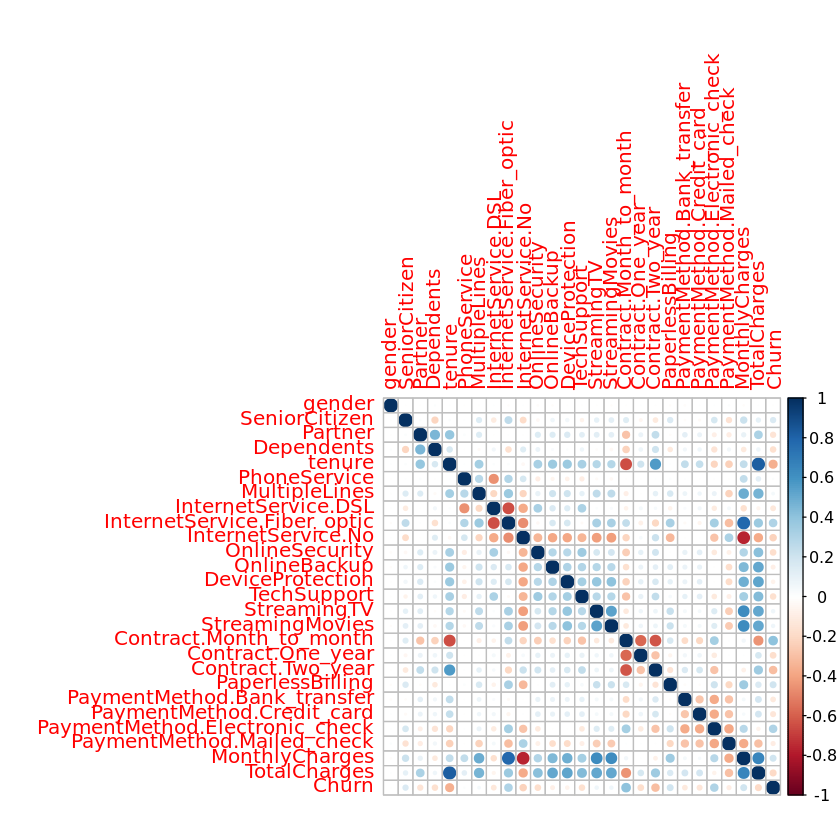

In [19]:
corrplot(res,method="circle")

In [20]:
# Drop column TotalCharges to prevent multicollinearity
train_data <- subset(df, select = -c(TotalCharges))

## Splitting data into training and validation set

In [21]:
trainIndex <- createDataPartition(df$Churn, p = .7, # p=0.7: 70% of data is in training set, 
                                  list = FALSE,
                                  times = 1) # times = 1: we partition the data once

In [22]:
train_data <- df[trainIndex, ]
validation_data <- df[-trainIndex, ]

In [23]:
# Oversample training data due to imbalanced labels
train_data <- ovun.sample(Churn ~ ., data = train_data, method = "over",N = 7200)$data

In [24]:
# Distribution of labels
table(train_data$Churn)


   0    1 
3615 3585 

## Modelling

### Helper functions

In [25]:
# Code from another module
diagnosticsChurn = function(treemodel, testdata, threshold = 0.5){
  
  # uses the 'treemodel' to predict the 'Churn' using the 'testdata' and then it converts the predicted probabilities to binary depending on the specified threshold.
  fitted_results = predict(treemodel,testdata,type="prob")
  fitted_results_binary = factor(ifelse(fitted_results[,1] > threshold, 0,1), levels = c(0,1))
  # prints the confusion matrix
  print(confusionMatrix(fitted_results_binary, testdata$Churn, positive="1"))
  # creates a prediction object from the fitted results and the actual data
  pr = prediction(fitted_results[,1], testdata$Churn)
  # creates a performance rate and ROC curve to plot
  prf = performance(pr, measure = "tpr", x.measure = "fpr")
  #Calculates the area under the ROC curve
  # auc = performance(pr, measure = "auc")
  # auc = auc@y.values[[1]]
  # plot(prf, main = 'ROC curve', sub = paste('AUC:', round(auc,3) ))
  # abline(0,1, col = "red", lty = 3)
  # cat("AUC: ", auc, "\n")
  #   list(accuracy = CM$overall[1], auc = auc)
}

In [26]:
importanceOfVariables = function(model) {
    # Gets the variables sorted by importance
    table <- varImp(model) %>% arrange(desc(Overall))
    # Prints top 6 variables
    head(table)
}

## Logistic Regression

In [27]:
fullModel <- glm(Churn~ ., family = 'binomial', data=train_data)

In [28]:
str(train_data)

'data.frame':	7200 obs. of  27 variables:
 $ gender                        : Factor w/ 2 levels "Female","Male": 2 2 2 2 2 2 1 1 2 1 ...
 $ SeniorCitizen                 : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Partner                       : Factor w/ 2 levels "0","1": 1 1 1 2 2 1 2 1 1 1 ...
 $ Dependents                    : Factor w/ 2 levels "0","1": 1 1 2 2 1 1 2 1 2 1 ...
 $ tenure                        : int  34 45 62 13 58 25 69 52 71 21 ...
 $ PhoneService                  : Factor w/ 2 levels "0","1": 2 1 2 2 2 2 2 2 2 2 ...
 $ MultipleLines                 : Factor w/ 2 levels "0","1": 1 1 1 1 2 1 2 1 2 1 ...
 $ InternetService.DSL           : int  1 1 1 1 0 0 0 0 0 0 ...
 $ InternetService.Fiber_optic   : int  0 0 0 0 1 1 1 0 1 1 ...
 $ InternetService.No            : int  0 0 0 0 0 0 0 1 0 0 ...
 $ OnlineSecurity                : Factor w/ 2 levels "0","1": 2 2 2 2 1 2 2 1 2 1 ...
 $ OnlineBackup                  : Factor w/ 2 levels "0","1": 1 1 2 1 1 1 

In [29]:
summary(fullModel)


Call:
glm(formula = Churn ~ ., family = "binomial", data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3276  -0.7597  -0.1276   0.7497   2.9005  

Coefficients: (3 not defined because of singularities)
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    -7.806e-01  2.077e-01  -3.759 0.000171 ***
genderMale                      5.686e-02  5.916e-02   0.961 0.336451    
SeniorCitizen1                  2.585e-01  7.995e-02   3.233 0.001226 ** 
Partner1                       -1.442e-02  7.146e-02  -0.202 0.840091    
Dependents1                    -1.548e-01  8.029e-02  -1.928 0.053852 .  
tenure                         -5.156e-02  4.716e-03 -10.934  < 2e-16 ***
PhoneService1                   4.459e-01  5.948e-01   0.750 0.453401    
MultipleLines1                  4.938e-01  1.628e-01   3.034 0.002416 ** 
InternetService.DSL             2.247e+00  7.409e-01   3.033 0.002421 ** 
InternetService.Fi

In [30]:
confusionMatrix(table(predict(fullModel, newdata = validation_data, type="response") >= 0.5, validation_data$Churn == 1))

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


Confusion Matrix and Statistics

       
        FALSE TRUE
  FALSE  1120  111
  TRUE    428  449
                                          
               Accuracy : 0.7443          
                 95% CI : (0.7251, 0.7628)
    No Information Rate : 0.7343          
    P-Value [Acc > NIR] : 0.156           
                                          
                  Kappa : 0.4449          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.7235          
            Specificity : 0.8018          
         Pos Pred Value : 0.9098          
         Neg Pred Value : 0.5120          
             Prevalence : 0.7343          
         Detection Rate : 0.5313          
   Detection Prevalence : 0.5840          
      Balanced Accuracy : 0.7626          
                                          
       'Positive' Class : FALSE           
                                          

In [31]:
reducedModel <- glm(Churn~SeniorCitizen + tenure + TechSupport + Contract.Month_to_month + PaperlessBilling + TotalCharges + PaymentMethod.Electronic_check, family="binomial", data = train_data)

In [32]:
summary(reducedModel)


Call:
glm(formula = Churn ~ SeniorCitizen + tenure + TechSupport + 
    Contract.Month_to_month + PaperlessBilling + TotalCharges + 
    PaymentMethod.Electronic_check, family = "binomial", data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1062  -0.7862  -0.1275   0.8264   2.8872  

Coefficients:
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    -7.476e-01  1.012e-01  -7.385 1.52e-13 ***
SeniorCitizen1                  4.624e-01  7.522e-02   6.147 7.90e-10 ***
tenure                         -6.775e-02  3.814e-03 -17.764  < 2e-16 ***
TechSupport1                   -4.565e-01  7.338e-02  -6.220 4.96e-10 ***
Contract.Month_to_month         1.166e+00  8.435e-02  13.827  < 2e-16 ***
PaperlessBilling1               5.195e-01  6.192e-02   8.390  < 2e-16 ***
TotalCharges                    5.386e-04  3.824e-05  14.083  < 2e-16 ***
PaymentMethod.Electronic_check  7.247e-01  5.939e-02  12.203  < 2e-16

In [33]:
confusionMatrix(table(predict(reducedModel, newdata = validation_data, type="response") >= 0.5, validation_data$Churn == 1))

Confusion Matrix and Statistics

       
        FALSE TRUE
  FALSE  1062   93
  TRUE    486  467
                                          
               Accuracy : 0.7253          
                 95% CI : (0.7057, 0.7443)
    No Information Rate : 0.7343          
    P-Value [Acc > NIR] : 0.8319          
                                          
                  Kappa : 0.4248          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.6860          
            Specificity : 0.8339          
         Pos Pred Value : 0.9195          
         Neg Pred Value : 0.4900          
             Prevalence : 0.7343          
         Detection Rate : 0.5038          
   Detection Prevalence : 0.5479          
      Balanced Accuracy : 0.7600          
                                          
       'Positive' Class : FALSE           
                                          

### Decision tree

In [34]:
treemodel = rpart(Churn ~ .,
                  data = train_data,
                  method = "class",
                  control = rpart.control(maxsurrogate = 0))

In [35]:
diagnosticsChurn(treemodel, validation_data)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1131  109
         1  417  451
                                          
               Accuracy : 0.7505          
                 95% CI : (0.7314, 0.7688)
    No Information Rate : 0.7343          
    P-Value [Acc > NIR] : 0.04857         
                                          
                  Kappa : 0.456           
                                          
 Mcnemar's Test P-Value : < 2e-16         
                                          
            Sensitivity : 0.8054          
            Specificity : 0.7306          
         Pos Pred Value : 0.5196          
         Neg Pred Value : 0.9121          
             Prevalence : 0.2657          
         Detection Rate : 0.2139          
   Detection Prevalence : 0.4118          
      Balanced Accuracy : 0.7680          
                                          
       'Positive' Class : 1               
                        

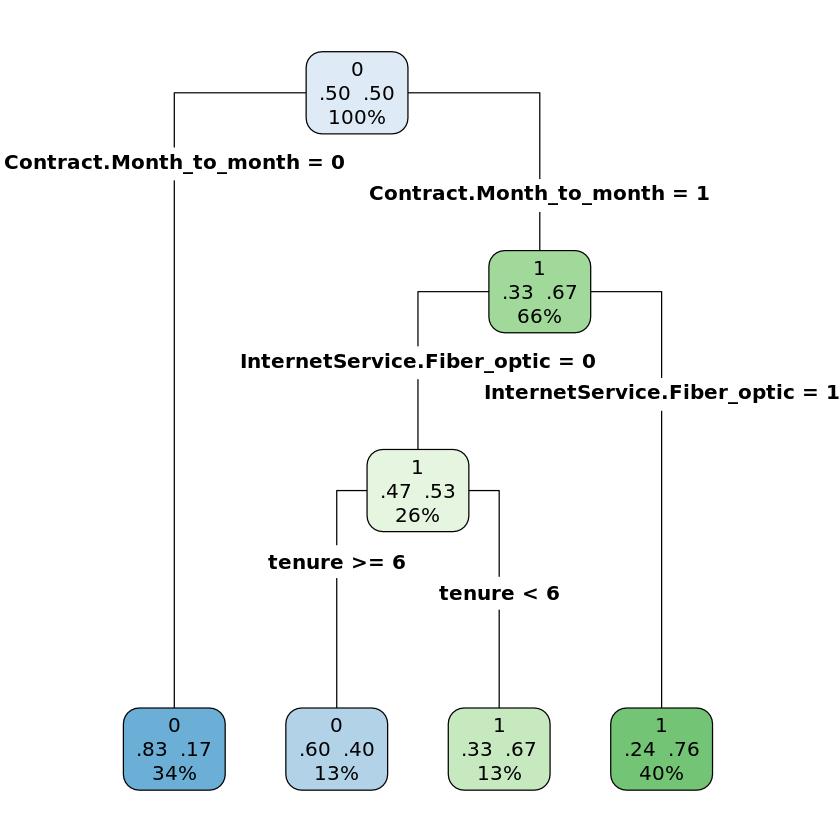

In [36]:
rpart.plot(treemodel,type = 4,clip.right.labs = F,extra=104)

In [37]:
treemodel = rpart(Churn ~ .,
                  data = train_data,
                   method = "class",
                   control = rpart.control(maxsurrogate = 0))

In [38]:
diagnosticsChurn(treemodel, validation_data)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1131  109
         1  417  451
                                          
               Accuracy : 0.7505          
                 95% CI : (0.7314, 0.7688)
    No Information Rate : 0.7343          
    P-Value [Acc > NIR] : 0.04857         
                                          
                  Kappa : 0.456           
                                          
 Mcnemar's Test P-Value : < 2e-16         
                                          
            Sensitivity : 0.8054          
            Specificity : 0.7306          
         Pos Pred Value : 0.5196          
         Neg Pred Value : 0.9121          
             Prevalence : 0.2657          
         Detection Rate : 0.2139          
   Detection Prevalence : 0.4118          
      Balanced Accuracy : 0.7680          
                                          
       'Positive' Class : 1               
                        

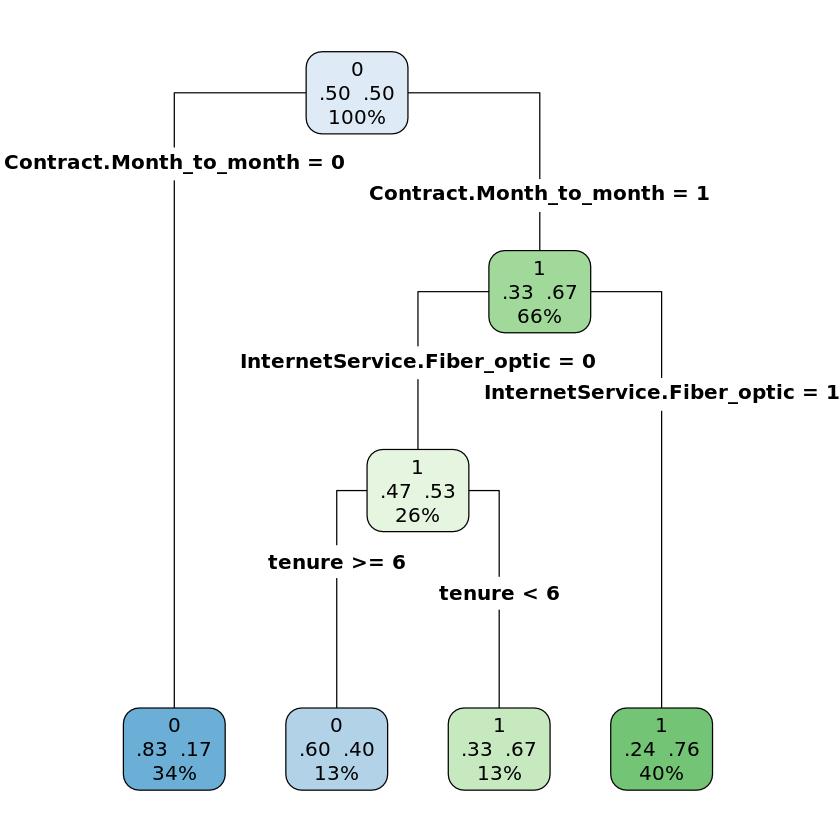

In [39]:
rpart.plot(treemodel,type = 4,clip.right.labs = F,extra=104)

### Pruning decision tree


Classification tree:
rpart(formula = Churn ~ ., data = train_data, method = "class", 
    control = rpart.control(maxsurrogate = 0))

Variables actually used in tree construction:
[1] Contract.Month_to_month     InternetService.Fiber_optic
[3] tenure                     

Root node error: 3585/7200 = 0.49792

n= 7200 

        CP nsplit rel error  xerror     xstd
1 0.451883      0   1.00000 1.01060 0.011834
2 0.027057      1   0.54812 0.54812 0.010543
3 0.010000      3   0.49400 0.49400 0.010193


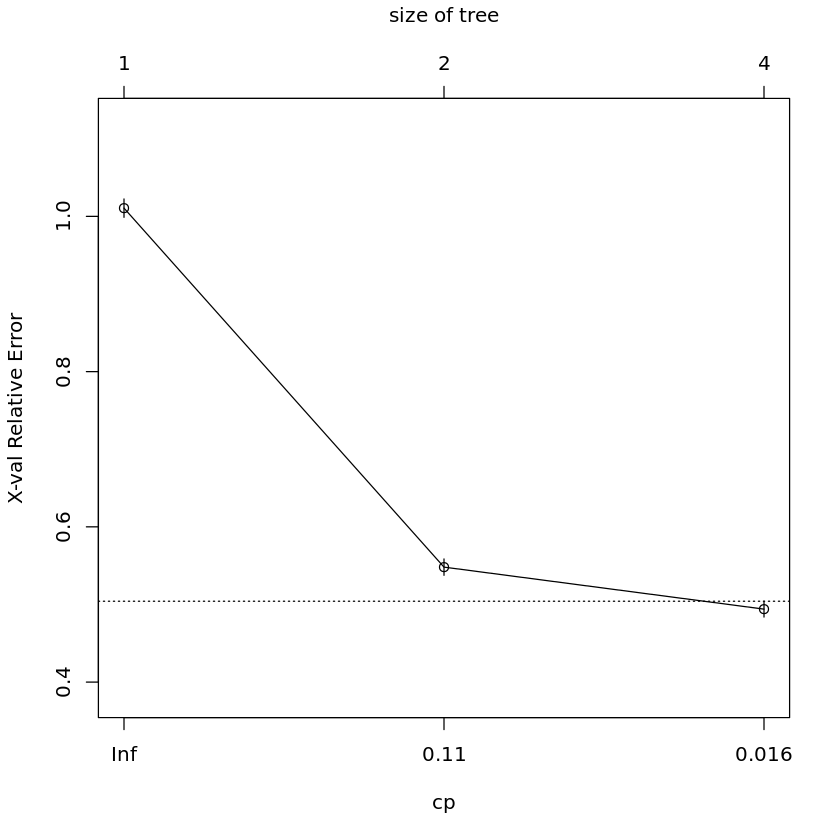

In [40]:
printcp(treemodel)
plotcp(treemodel)

Call:
rpart(formula = Churn ~ ., data = train_data, method = "class", 
    control = rpart.control(maxsurrogate = 0))
  n= 7200 

          CP nsplit rel error    xerror       xstd
1 0.45188285      0 1.0000000 1.0105997 0.01183418
2 0.02705718      1 0.5481172 0.5481172 0.01054349
3 0.01000000      3 0.4940028 0.4940028 0.01019328

Variable importance
    Contract.Month_to_month InternetService.Fiber_optic 
                         81                          12 
                     tenure 
                          7 

Node number 1: 7200 observations,    complexity param=0.4518828
  predicted class=0  expected loss=0.4979167  P(node) =1
    class counts:  3615  3585
   probabilities: 0.502 0.498 
  left son=2 (2464 obs) right son=3 (4736 obs)
  Primary splits:
      Contract.Month_to_month        < 0.5    to the left,  improve=829.4621, (0 missing)
      Contract.Two_year              < 0.5    to the right, improve=491.9858, (0 missing)
      tenure                         < 22.5  

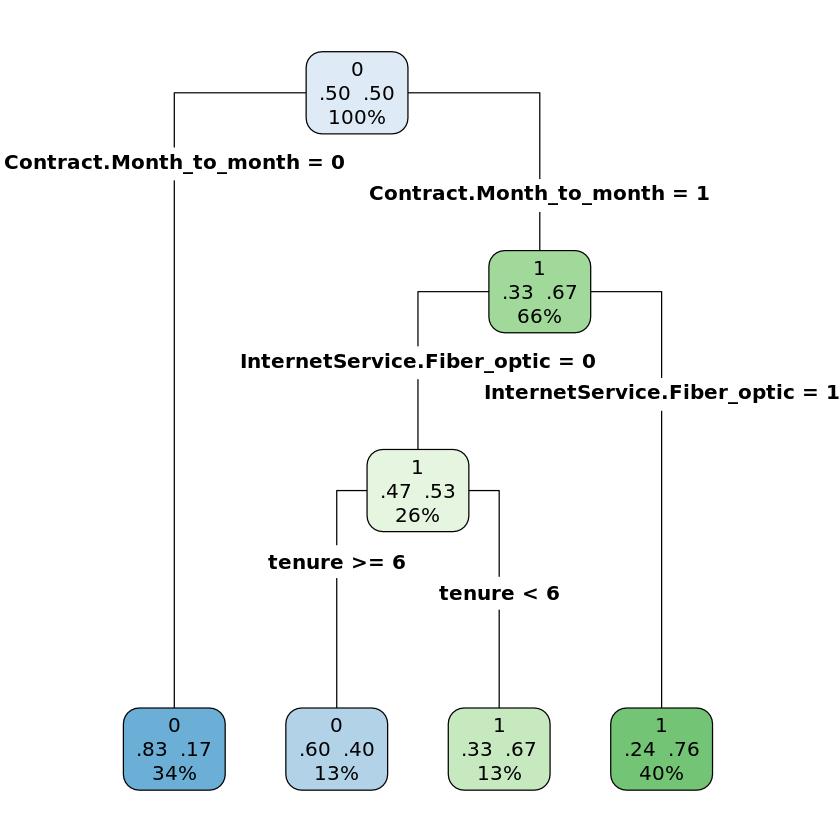

In [48]:
treemodel_prune = prune(treemodel, cp = 0.015, minsplit = 350, maxdepth = 3)
rpart.plot(treemodel_prune,type = 4,clip.right.labs = F,extra=104)
summary_model = summary(treemodel_prune)

diagnosticsChurn(treemodel_prune, validation_data)


In [49]:
importanceOfVariables(treemodel_prune)

,Overall
,<dbl>
Contract.Month_to_month,829.4621
tenure,589.3502
InternetService.Fiber_optic,531.4686
Contract.Two_year,491.9858
PaymentMethod.Electronic_check,482.0008
MonthlyCharges,119.0772


### Bagging

In [43]:
churnBag = bagging(Churn ~., data = train_data, nbagg = 25)
diagnosticsChurn(churnBag, validation_data)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1330  257
         1  218  303
                                          
               Accuracy : 0.7747          
                 95% CI : (0.7562, 0.7923)
    No Information Rate : 0.7343          
    P-Value [Acc > NIR] : 1.139e-05       
                                          
                  Kappa : 0.4093          
                                          
 Mcnemar's Test P-Value : 0.08124         
                                          
            Sensitivity : 0.5411          
            Specificity : 0.8592          
         Pos Pred Value : 0.5816          
         Neg Pred Value : 0.8381          
             Prevalence : 0.2657          
         Detection Rate : 0.1437          
   Detection Prevalence : 0.2472          
      Balanced Accuracy : 0.7001          
                                          
       'Positive' Class : 1               
                        

In [44]:
importanceOfVariables(churnBag)

,Overall
,<dbl>
tenure,1730.1788
MonthlyCharges,1662.1496
TotalCharges,1621.6917
Contract.Month_to_month,824.8776
PaymentMethod.Electronic_check,767.2829
InternetService.Fiber_optic,593.7946


### Random forest

In [45]:
set.seed(123)

In [46]:
rf <- randomForest(Churn ~ ., data=train_data)

In [47]:
diagnosticsChurn(rf, validation_data)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1294  187
         1  254  373
                                         
               Accuracy : 0.7908         
                 95% CI : (0.7728, 0.808)
    No Information Rate : 0.7343         
    P-Value [Acc > NIR] : 1.062e-09      
                                         
                  Kappa : 0.4835         
                                         
 Mcnemar's Test P-Value : 0.001673       
                                         
            Sensitivity : 0.6661         
            Specificity : 0.8359         
         Pos Pred Value : 0.5949         
         Neg Pred Value : 0.8737         
             Prevalence : 0.2657         
         Detection Rate : 0.1769         
   Detection Prevalence : 0.2974         
      Balanced Accuracy : 0.7510         
                                         
       'Positive' Class : 1              
                                         


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e98d80dd-e998-4fe6-9896-58109e021771' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>